## Домашнее задание №3

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [15]:
import numpy as np

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Вернемся к задаче распознавания рукописных цифр, рассмотренной на первом занятии. Все также будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на пример, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 1')

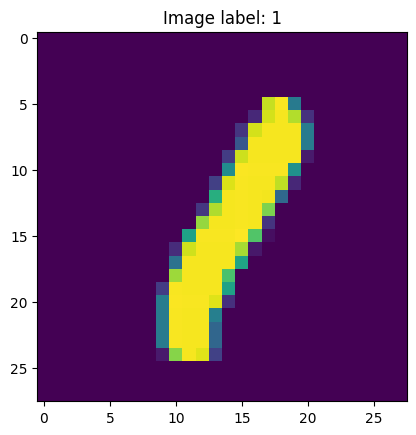

In [4]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

**Matvey26:**  *Посмотрим на размерность*

In [10]:
train_mnist_data.data.shape

torch.Size([60000, 28, 28])

**Matvey26:** *Теперь посмотрим на то, как устроен отдельный объект*

In [14]:
print(_image[0, 0])
print(_image[0, 12])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6275, 0.9882, 0.9922, 0.9882, 0.9843,
        0.3373, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


**Matvey26:** *Таким образом, данные представляют собой матрицы размера 28 на 28, где каждый пиксель - вещественное число от 0 до 1, где 0 - отсутствие цвета.*

**Matvey26:** *На выходе модели - 10 классов. В теории, конечно, можно обучать регрессию, но смысла в этом никакого нет - будем предсказывать вероятности классов*

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DigitRecognition(nn.Module):
    def __init__(self, img_width, img_height, num_classes=10):
        super().__init__()
        self.img_width = img_width
        self.img_height = img_height
        self.num_classes = num_classes

        HIDDEN_DIM = 128
        
        self.layers = nn.Sequential(
            nn.Linear(img_width * img_height, HIDDEN_DIM),
            nn.SiLU(),
            nn.Dropout(0.1),
            
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM // 2),
            nn.SiLU(),
            nn.Dropout(0.1),
            
            nn.Linear(HIDDEN_DIM // 2, num_classes)
        )

    def forward(self, x):
        x = x.view(-1, self.img_width * self.img_height)
        return self.layers(x)

    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            return F.softmax(logits, dim=1)

    def fit(self, dataloader, n_epochs=1, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

        self.train()
        
        for epoch in range(n_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            for images, labels in dataloader:
                optimizer.zero_grad()

                outputs = self.forward(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = 100 * correct / total

            scheduler.step(epoch_loss)

            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        
        self.eval()

IMG_WIDTH = IMG_HEIGHT = 28
NUM_CLASSES = 10

model = DigitRecognition(IMG_WIDTH, IMG_HEIGHT, NUM_CLASSES)

Локальные тесты для проверки вашей модели доступны ниже:

In [27]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. В качестве примера можете воспользоваться ноутбуком с занятия №1. Также рекомендуем поработать с различными оптимизаторами.

In [28]:
model.fit(train_data_loader, n_epochs=2)

Epoch [1/2], Loss: 0.3125, Accuracy: 90.78%
Epoch [2/2], Loss: 0.1324, Accuracy: 96.00%


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [29]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [21]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.97788


In [30]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [31]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9702


Проверка, что необходимые пороги пройдены:

In [32]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw03_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [ ]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy

In [ ]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw03_data_dict.npy'), 'Please, download `hw03_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw03_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).tolist(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).tolist()
}

# этот файл проверяющая система отказывается проверять
# np.save('submission_dict_hw03.npy', submission_dict, allow_pickle=True)
# print('File saved to `submission_dict_hw03.npy`')

# Конвертируем списки чисел в строки с запятыми
submission_dict_str = {
    'train': ','.join(map(str, submission_dict['train'])),
    'test': ','.join(map(str, submission_dict['test']))
}

import json
with open('submission_dict_hw03.json', 'w') as f:
    json.dump(submission_dict_str, f)

print('File saved to `submission_dict_hw03.json` (comma-separated format)')

# __________end of block__________

File saved to `submission_dict_hw03.npy`
File saved to `submission_dict_hw03.json`
File saved to `submission_dict_hw03.json` (comma-separated format)


На этом задание завершено. Поздравляем!